In [1]:
# Import the necessary modules and libraries.
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import matplotlib.pyplot as plt
from IPython.display import Image
from six import StringIO
import pydot
from matplotlib.colors import ListedColormap

In [2]:
seed = 42
np.random.seed(seed)

In [3]:
# Define utility functions.
def plot_regression_predictions(tree_reg, X, y, y_noisy, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(x, y_noisy, 'o', color="orange", label='Noisy function')
    plt.plot(X, y, "b.", label='Target function')
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"Predicted function")
    plt.legend() #loc="upper center", fontsize=18
    plt.grid()

### Gerando os dados.

A função objetivo tem a seguinte forma

$$y=4(x-0.5)^2$$

In [4]:
# Quadratic training set + noise.
N = 200
x = np.random.rand(N, 1)

# Target function.
y = 4 * (x - 0.5) ** 2

# Noise.
w = np.sqrt(0.01)*np.random.randn(N, 1)

# Observable function.
y_noisy = y + w

# Create validation set.
x_test = np.linspace(0.0, 1.0, N).reshape(N, 1)
y_test = 4 * (x_test - 0.5) ** 2

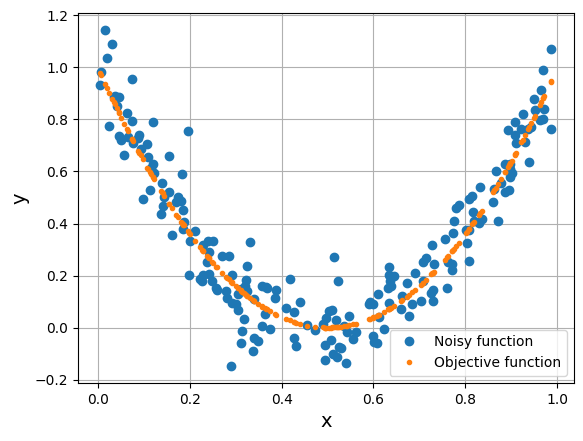

In [5]:
plt.plot(x, y_noisy, 'o', label='Noisy function')
plt.plot(x, y, '.', label='Objective function')
plt.grid()
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend()
plt.show()

### Variando o hiperparâmetro 'max_depth'

In [6]:
# Instantiate and train the regression trees.
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg3 = DecisionTreeRegressor(random_state=42)

tree_reg1.fit(x, y_noisy)
tree_reg2.fit(x, y_noisy)
tree_reg3.fit(x, y_noisy)

DecisionTreeRegressor(random_state=42)

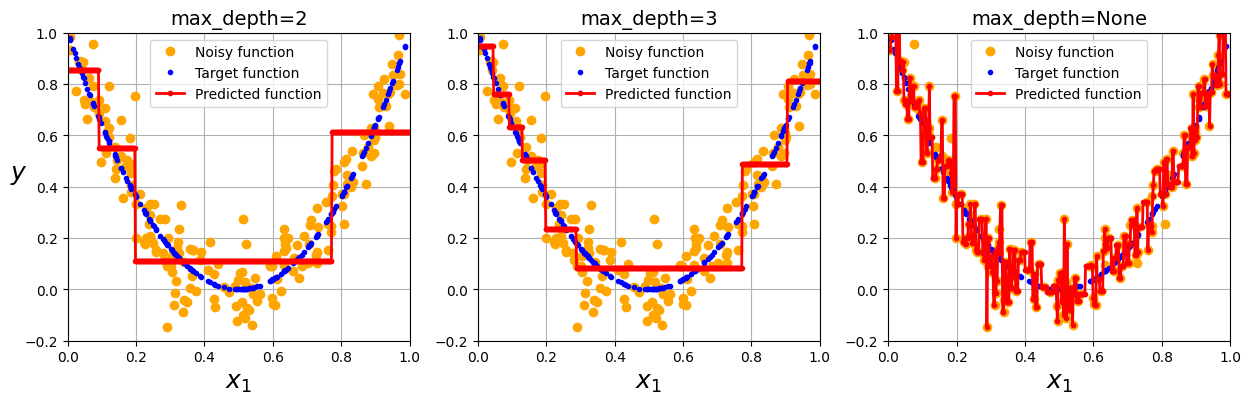

In [7]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plot_regression_predictions(tree_reg1, x, y, y_noisy)
plt.title("max_depth=2", fontsize=14)

plt.subplot(132)
plot_regression_predictions(tree_reg2, x, y, y_noisy, ylabel=None)
plt.title("max_depth=3", fontsize=14)

plt.subplot(133)
plot_regression_predictions(tree_reg3, x, y, y_noisy, ylabel=None)
plt.title("max_depth="+str(tree_reg3.max_depth), fontsize=14)

plt.show()

+ Predições feitas por árvores de decisão **não são suaves nem contínuas**, mas **aproximações feitas por partes/trechos**.


+ Observem como o **valor previsto para cada trecho é sempre o valor médio dos exemplos nesse trecho**.


+ Assim como em tarefas de classificação, as árvores de decisão tendem a se sobreajustar ao conjunto de treinamento ao lidar com tarefas de regressão.
    + Sem restrição (regularização) alguma, a árvore se sobreajusta.
    + Com muita restrição, (`max_depth=2`), a árvore subajusta.

### Variando o hiperparâmetro 'min_samples_leaf'

+ `min_samples_leaf`: define o número mínimo de exemplos que os nós (esquerda e direita) devem ter após a divisão.


+ Diminuir `min_samples_leaf` causa sobreajuste.


+ Aumentar `min_samples_leaf` causa subajuste.

In [8]:
# Instantiate and train the regression trees.
tree_reg0 = DecisionTreeRegressor(random_state=42)
tree_reg1 = DecisionTreeRegressor(random_state=42, min_samples_leaf=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=5)
tree_reg3 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)

tree_reg0.fit(x, y_noisy)
tree_reg1.fit(x, y_noisy)
tree_reg2.fit(x, y_noisy)
tree_reg3.fit(x, y_noisy)

DecisionTreeRegressor(min_samples_leaf=10, random_state=42)

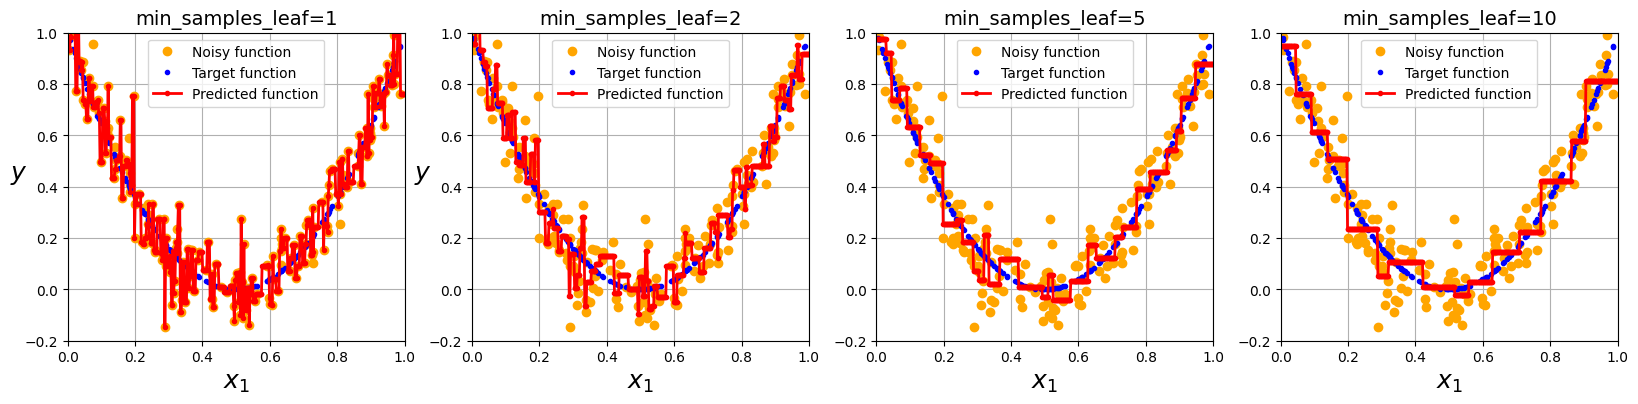

In [9]:
plt.figure(figsize=(20, 4))
plt.subplot(141)
plot_regression_predictions(tree_reg0, x, y, y_noisy)
plt.title("min_samples_leaf="+str(tree_reg0.min_samples_leaf), fontsize=14)

plt.subplot(142)
plot_regression_predictions(tree_reg1, x, y, y_noisy)
plt.title("min_samples_leaf="+str(tree_reg1.min_samples_leaf), fontsize=14)

plt.subplot(143)
plot_regression_predictions(tree_reg2, x, y, y_noisy, ylabel=None)
plt.title("min_samples_leaf="+str(tree_reg2.min_samples_leaf), fontsize=14)

plt.subplot(144)
plot_regression_predictions(tree_reg3, x, y, y_noisy, ylabel=None)
plt.title("min_samples_leaf="+str(tree_reg3.min_samples_leaf), fontsize=14)

plt.show()

#### Observações


+ O algoritmo divide cada trecho de uma maneira que torna a maioria dos exemplos de treinamento o mais próximo possível do valor previsto.


+ Assim como em problemas de classificação, as **árvores de decisão** tendem a se ajustar demais ao lidar com tarefas de regressão.


+ Sem nenhuma regularização (ou seja, usando os hiperparâmetros padrão), obtemos a aproximação à esquerda da figura acima.
    + Obviamente, o modelo está sobreajustando ao conjunto de treinamento.


+ Porém, definir o hiperparâmetro `min_samples_leaf = 10` resulta em um modelo muito mais razoável, representado à direita da figura acima.


+ Aumentar o valor de `min_samples_leaf` faz com que menos trechos sejam criados, consequentemente, diminuindo a complexidade (i.e., graus de liberdade) do modelo.


+ Como podemos encontrar os valores ótimos para os hiperparâmetros?

### Usando Grid Search para o ajuste fino dos hiperparâmetros  'max_depth' e 'min_samples_leaf'

+ Grid Search é uma técnica de ajuste fino dos hiperparâmetros.


+ Testa todas as possíveis combinações de valores, i.e., **busca exaustiva**.

In [10]:
# Set parameters for grid-search.
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, None],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

# Instantiate DT class.
reg = DecisionTreeRegressor(random_state=42)

# Instantiate GridSearch class.
grid_search = GridSearchCV(reg, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Find best hyperparameters.
grid_search.fit(x, y_noisy)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, None],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='neg_mean_squared_error')

In [11]:
grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 6}

In [12]:
grid_search.best_score_

-0.010414130480370374

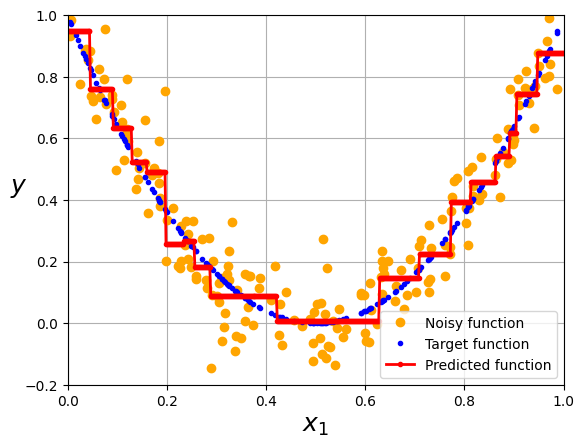

In [13]:
plot_regression_predictions(grid_search, x, y, y_noisy)

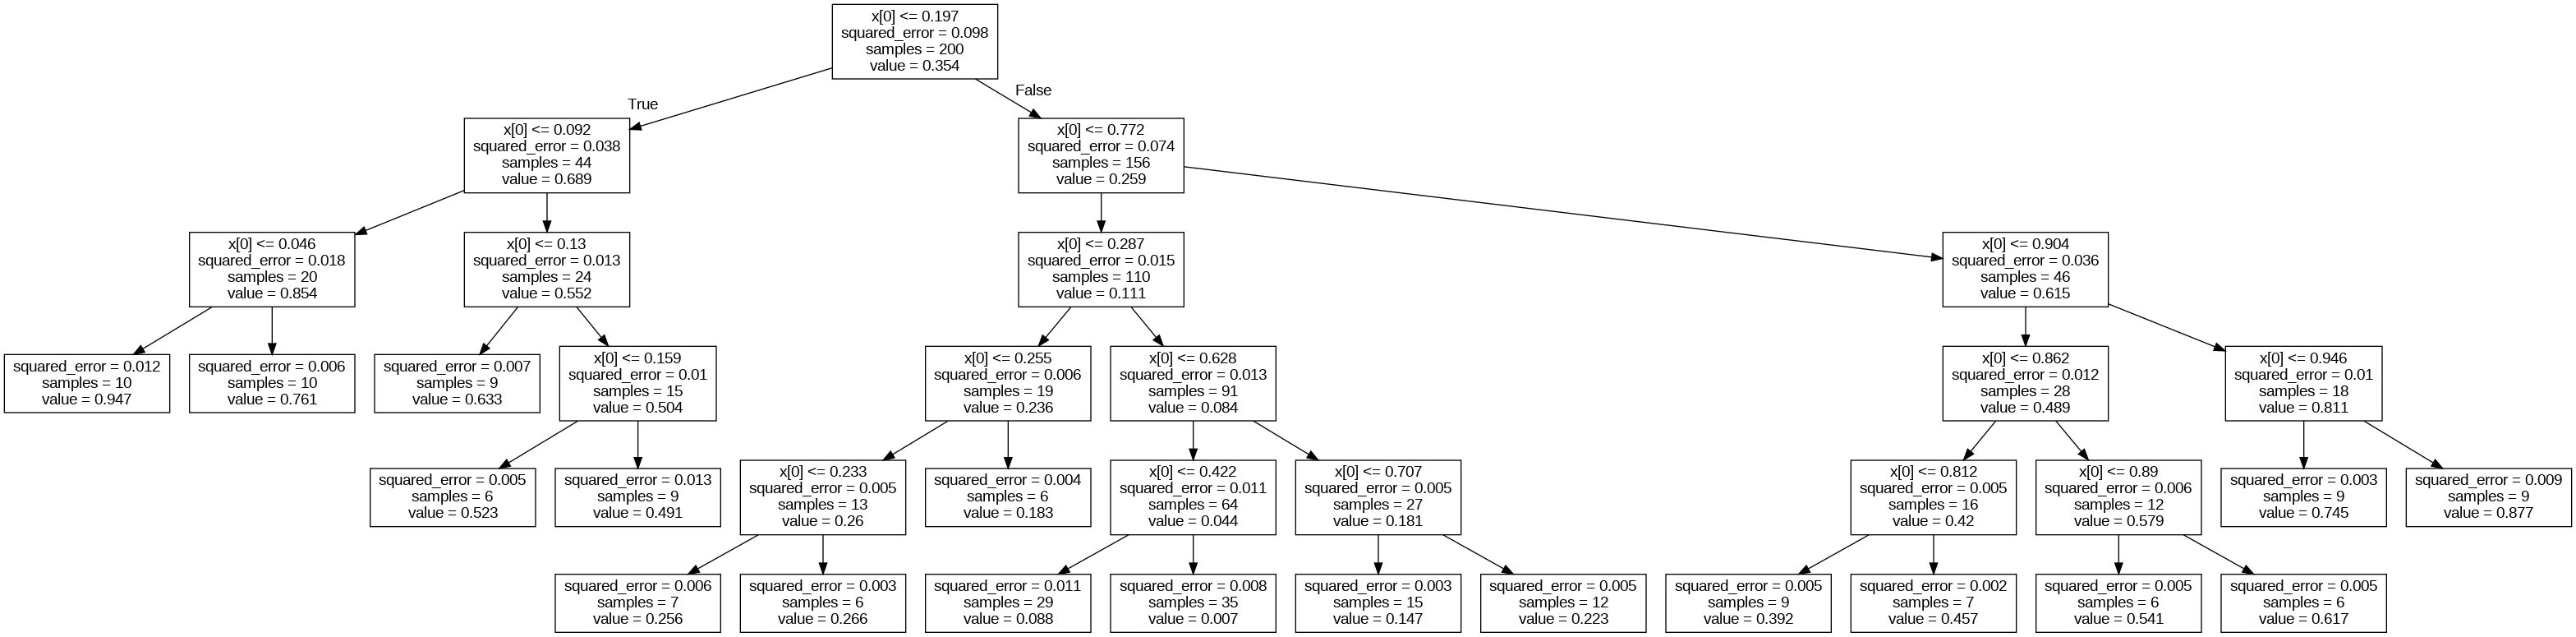

In [14]:
reg = DecisionTreeRegressor(random_state=42, max_depth=5, min_samples_leaf=6)
reg.fit(x, y_noisy)

# visualize the decision tree.
# you've got to have graphviz and pydot installed on your computer.
# Execute: conda install graphviz pydot
dot_data = StringIO()
tree.export_graphviz(reg, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())